# Exploratory Analysis of Spatial Data: Visualizing Spatial Autocorrelation

1. create static real examples Moran scatter plot, lisa cluster map and choropleth map
2. combine all three static visualizations
3. create interactive visualization in bokeh
5. create interactive mask connection

### To-Do:

* fix legends in 3 plot visualization
* include masking functionality in static 3 plot visualization
* interactive visualization
* fix colours

## Imports

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pysal as ps
import libpysal.api as lp
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
import splot.plot

from IPython.display import Image

## Example Data

First, we will load the Guerry.shp data from the example_data folder.

In [2]:
from pysal.contrib.pdio import read_files

link_to_data = os.path.join('..', 'example_data', 'guerry', 'Guerry.shp')
df = gpd.read_file(link_to_data)

For this example we will focus on the Donatns (charitable donations per capita) variable. We will calculate Contiguity weights `w` with `ps.queen_from_shapefile()`. Then we transform our weights to be row-standardized.

In [3]:
y = df['Donatns'].values
w = lp.Queen.from_dataframe(df)
w.transform = 'r'

## Assessing Global Spatial Autocorrelation

We calculate Moran's I. A test for global autocorrelation for a continuous attribute.

In [4]:
#fix installation
import esda

w = lp.Queen.from_dataframe(df)
moran = esda.moran.Moran(y, w)
moran.I

0.3533613255848606

Our value for the statistic is interpreted against a reference distribution under the null of complete spatial randomness. PySAL uses the approach of random spatial permutations.

Text(0.5,0,"Moran's I")

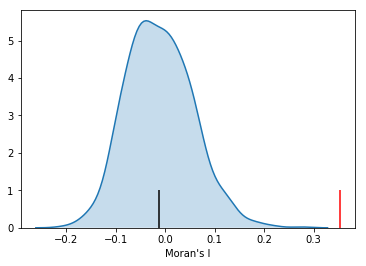

In [5]:
import seaborn as sbn
sbn.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

In [6]:
moran.p_sim

0.001

## Visualizing Local Autocorrelation with splot - Hot Spots, Cold Spots and Spatial Outliers

In addition to visualizing Global autocorrelation statistics, splot has options to visualize local autocorrelation statistics. We compute the local Moran `m`. Then, we plot the spatial lag and the Donatns variable in a Moran Scatterplot.

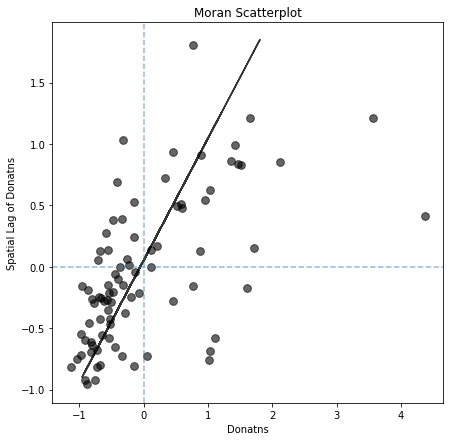

In [7]:
moran_loc = esda.moran.Moran_Local(y, w)
splot.plot.mplot(moran_loc, xlabel='Donatns', ylabel='Spatial Lag of Donatns',
      title='Moran Scatterplot', figsize=(7,7))
plt.show()

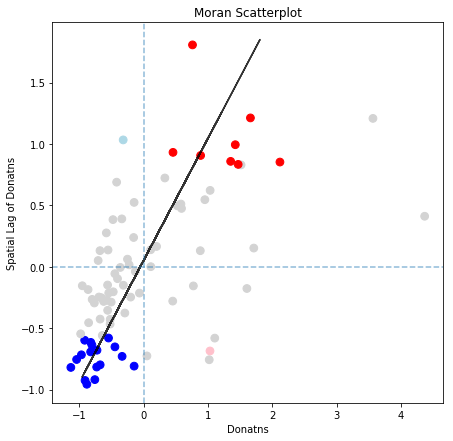

In [9]:
m = esda.moran.Moran_Local(y, w)
splot.plot.mplot(m, xlabel='Donatns', ylabel='Spatial Lag of Donatns',
                 title='Moran Scatterplot', figsize=(7,7), p=0.05, ax=None)

plt.show()

We can distinguish the specific type of local spatial autocorrelation in HH, LL, HL, LH.

Let's now visualize the areas we found to be significant on a map:

In [10]:
def lisa_cluster(m, p=0.05, figsize=None, ax=None, legend=True):
    
    import geopandas as gdp
    from matplotlib import colors

    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q==1)
    LL = 3 * (sig * moran_loc.q==3)
    LH = 2 * (sig * moran_loc.q==2)
    HL = 4 * (sig * moran_loc.q==4)
    
    spots = HH + LL + LH + HL
    spot_labels = [ '0 ns', '1 HH', '2 LH', '3 LL', '4 HL']
    labels = [spot_labels[i] for i in spots]
    
    hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
    
    if ax is None:
        f, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    df.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend=legend)
    ax.set_axis_off()
    
    return plt

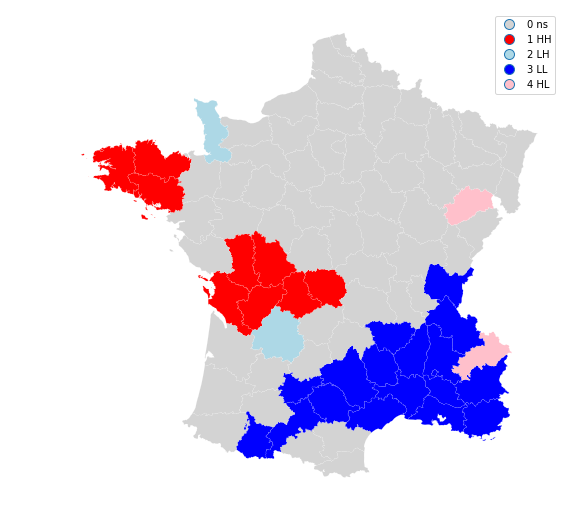

In [11]:
lisa_cluster(moran_loc, p=0.05, figsize = (9,9))

plt.show()

# Combined visualizations

Static visualization of Moran Scatterplot, LISA cluster map and choropleth map

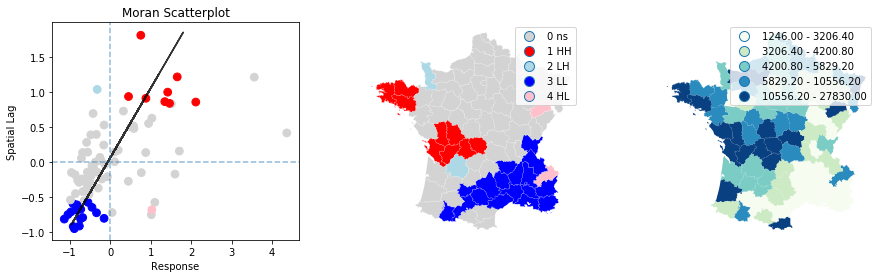

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from geopandas.plotting import plot_dataframe

def Moran_plot_pair(m, p, y, df, column):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4),
                            subplot_kw={'aspect':'equal'})
    
    splot.plot.mplot(m, xlabel='Response', ylabel='Spatial Lag',
      title='Moran Scatterplot', p=p, ax=axs[0])
    axs[0].set_aspect('auto')
    
    lisa_cluster(m, p, figsize=None, ax=axs[1], legend=True)
    
    df.plot(column=column, scheme='Quantiles', k=5, cmap='GnBu',
            legend=True, ax=axs[2])
    axs[2].set_axis_off()
    #legend_kwds={'loc': 'upper right'}
 #   legend = axs[2].get_legend()
  #  legend.set_bbox_to_anchor((0.95, 0.95))
   # return legend
#(loc='upper right', bbox_to_anchor=(0.95, 0.95))

legend = Moran_plot_pair(m, 0.05, y, df, "Donatns")

plt.show()